# Setup

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import random as rd
import os
from tqdm import tqdm
import tensorflow_addons as tfa
import pandas as pd
import matplotlib.gridspec as gridspec
from matplotlib.colorbar import Colorbar


plt.style.use(['science','ieee'])

os.chdir('/home/mathis/Stage M1/')

2022-06-23 14:42:17.349202: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-23 14:42:17.349362: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Oracle

In [2]:
#GeV [min,max]

M1_range = M2_range = M3_range = [50, 5000]
mA_range = [50, 5000]
tanB_range = [2, 60]
mu_range = [-10**4, 10**4]
At_range = Ab_range = Atau_range = [-10**4, 10**4]
Mq1L_range = Mq3L_range = [50, 5000]
MuR_range = MdR_range = MtR_range = MbR_range = [50, 5000]
MeL_range = MtauL_range = MeR_range = MtauR_range = [50, 5000]

PMSSM_range_big= [M1_range, M2_range, M3_range, mA_range, tanB_range, mu_range, At_range, Ab_range, 
              Atau_range, Mq1L_range, Mq3L_range, MuR_range, MdR_range, MtR_range, MbR_range,
             MeL_range, MtauL_range, MeR_range, MtauR_range]

PMSSM_min = np.array([i[0] for i in PMSSM_range_big])
PMSSM_max = np.array([i[1] for i in PMSSM_range_big])

PMSSM_sub = np.subtract(PMSSM_max, PMSSM_min)

PMSSM_range = [PMSSM_min,PMSSM_max,PMSSM_sub]

In [3]:
def write_slha(PMSSM_NN, nom_slha):
    f = open(nom_slha, "w")
    
    f.write("BLOCK MODSEL \n")
    f.write(" 1    0              #MSSM \n")
    
    f.write("BLOCK SMINPUTS \n")
    f.write("  1   1.279340000e+02     # alpha^(-1) SM MSbar(M1) \n")
    f.write("  2   1.663700000e-05     # G_Fermi \n")
    f.write("  3   0.1179              # alphas(MS) SM MSbar \n")
    f.write("  4   91.1876             # MZ(pole) \n")
    f.write("  5   4.18                # mb(mb) SM MSbar \n")
    f.write("  6   172.9               # mtop(pole) \n")
    f.write("  7   1.776860000e+00     #m mtau(pole) \n")
    
    f.write("BLOCK MINPAR \n")
    f.write("  3   "+str(PMSSM_NN[4])+"   #tanb \n")
    
    f.write("BLOCK VCKMIN   #CKM param (Wolfenstein) \n")
    f.write("  1   0.22650  #lambda \n")
    f.write("  2   0.790    #A \n")
    f.write("  3   0.141    #rho \n")
    f.write("  4   0.357    #eta \n")
    
    f.write("BLOCK EXTPAR \n")
    f.write("  0   "+str(-1.0)+"               # Q \n")
    f.write("  1   "+str(PMSSM_NN[0])+"        # M1 \n")
    f.write("  2   "+str(PMSSM_NN[1])+"        # M2 \n")
    f.write("  3   "+str(PMSSM_NN[2])+"        # M3 \n")
    f.write("  11   "+str(PMSSM_NN[6])+"       # At \n")
    f.write("  12   "+str(PMSSM_NN[7])+"       # Ab \n")
    f.write("  13   "+str(PMSSM_NN[8])+"       # Atau \n")
    f.write("  23   "+str(PMSSM_NN[5])+"       # Mu \n")
    f.write("  26   "+str(PMSSM_NN[3])+"       # Ma \n")
    f.write("  31   "+str(PMSSM_NN[15])+"      # MeL \n")
    f.write("  32   "+str(PMSSM_NN[15])+"      # MmuL \n")
    f.write("  33   "+str(PMSSM_NN[16])+"      # MstauL \n")
    f.write("  34   "+str(PMSSM_NN[17])+"      # MeR \n")
    f.write("  35   "+str(PMSSM_NN[17])+"      # MmuR \n")
    f.write("  36   "+str(PMSSM_NN[18])+"      # MstauR \n")
    f.write("  41   "+str(PMSSM_NN[9])+"       # Mq1L \n")
    f.write("  42   "+str(PMSSM_NN[9])+"       # Mq2L \n")
    f.write("  43   "+str(PMSSM_NN[10])+"      # Mq3L \n")
    f.write("  44   "+str(PMSSM_NN[11])+"      # MquR \n")
    f.write("  45   "+str(PMSSM_NN[11])+"      # MqcR \n")
    f.write("  46   "+str(PMSSM_NN[13])+"      # MqtR \n")
    f.write("  47   "+str(PMSSM_NN[12])+"      # MqdR \n")
    f.write("  48   "+str(PMSSM_NN[12])+"      # MqsR \n")
    f.write("  49   "+str(PMSSM_NN[14])+"      # MqbR \n")
    
    f.close()

In [4]:
def Oracle(logits, PMSSM_range, ratio, succes_path):
    
    PMSSM_AL = np.add(np.multiply(logits,PMSSM_range[2]),PMSSM_range[0])
    
    write_slha(PMSSM_AL, "Advanced NN/AL/pmssm_al.in")    
    
    os.system('./SUSY/softsusy-4.1.9/softpoint.x leshouches < Advanced\ NN/AL/pmssm_al.in > Advanced\ NN/AL/pmssm_al.out')
            
          
    if os.path.getsize('/home/mathis/Stage M1/Advanced NN/AL/pmssm_al.out') == 0 :
        ratio[0]+=1
        return 0
        
    with open('Advanced NN/AL/pmssm_al.out') as slha_out:
        content = slha_out.read()
        if 'SOFTSUSY problem' in content:
            ratio[0]+=1
            return 0
        if 'LSP # Warning' in content:
            ratio[0]+=1
            return 0
    
    
    
    ratio[1]+=1
    commande = 'mv Advanced\ NN/AL/pmssm_al.out '
    nom_fichier = 'pmssm_al_succes_'+str(ratio[1])+'.out'
    os.system(commande+succes_path+nom_fichier)
    return 1   

# Model

In [5]:
path = 'Advanced NN/AL/AL_run/'
folder_r = '2022-06-08-08:57:07_II'

discriminator = tf.keras.models.load_model(path+folder_r+'/model_II.h5')
discriminator.summary()


fnc_activation = 'relu'
fnc_activation_output = 'sigmoid'
inputs = tf.keras.Input(shape=(100,), dtype='float32')
x = keras.layers.Dense(100, trainable=True, activation=fnc_activation)(inputs)
x = keras.layers.Dropout(1e-2)(x)
x = keras.layers.Dense(100, trainable=True, activation=fnc_activation)(x)
x = keras.layers.Dropout(1e-2)(x)
x = keras.layers.Dense(100, trainable=True, activation=fnc_activation)(x)
outputs = keras.layers.Dense(19, activation=fnc_activation_output)(x)
generator = tf.keras.Model(inputs,outputs)
generator.summary()


lr = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)


loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False, reduction='sum_over_batch_size')
#False pour une probabilité ie [0;1]

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 19)]              0         
                                                                 
 dense (Dense)               (None, 100)               2000      
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 12,201
Trainable params: 12,201
Non-trainable params: 0
_________________________________________________________________
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]

2022-06-23 14:42:27.591081: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-23 14:42:27.591108: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-23 14:42:27.591127: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (MPC): /proc/driver/nvidia/version does not exist
2022-06-23 14:42:27.591363: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Initial training

In [6]:
os.system('rm -r Advanced\ NN/AL/softsusy_succes_IT/')
os.system('mkdir -p Advanced\ NN/AL/softsusy_succes_IT')
succes_path_IT = 'Advanced\ NN/AL/softsusy_succes_IT/'

ratio_IT = [0,0]


K_size = 100
train_step = 50

loss_evolution_d = []
loss_evolution_g = []

for step , i in enumerate(range(train_step)):
    print('Step {} / {}'.format(i+1,train_step))
    
    batch = [[rd.uniform(0,1) for j in range(100)] for k in range(K_size)]
    batch = tf.convert_to_tensor(batch)
    
    
    with tf.GradientTape(persistent=True) as tape:
        logits_g = generator(batch)
    
        pred_g = []
        for j in tqdm(logits_g):
            pred = Oracle(j, PMSSM_range, ratio_IT, succes_path_IT)
            pred_g.append(pred)
    

        logits_d = discriminator(logits_g)
        
        
        true = tf.convert_to_tensor([pred_g])
        true = tf.transpose(true)      
        true_prime = tf.cast(true, dtype=tf.float32)

        loss_d = loss_fn(true_prime,logits_d)
        loss_evolution_d.append(loss_d)
        
        gradients_d = tape.gradient(loss_d, discriminator.trainable_weights)
        optimizer.apply_gradients(zip(gradients_d, discriminator.trainable_weights))
    
        #loss_g = loss_d
        loss_g = tf.math.abs(tf.math.subtract(1,loss_d))
        #loss_g = tf.convert_to_tensor(1-ratio_IT[1]/(ratio_IT[1]+ratio_IT[0]))
        loss_evolution_g.append(loss_g)
        
        gradients_g = tape.gradient(loss_g, generator.trainable_weights)
        optimizer.apply_gradients(zip(gradients_g, generator.trainable_weights))
        
    
print("Nombre d'échecs:",ratio_IT[0])
print("Nombre de succes:",ratio_IT[1])

Step 1 / 50


100%|█████████████████████████████████████████| 100/100 [00:05<00:00, 16.88it/s]

Step 2 / 50


100%|█████████████████████████████████████████| 100/100 [00:05<00:00, 17.10it/s]


Step 3 / 50


100%|█████████████████████████████████████████| 100/100 [00:07<00:00, 13.63it/s]


Step 4 / 50


100%|█████████████████████████████████████████| 100/100 [00:05<00:00, 17.17it/s]


Step 5 / 50


100%|█████████████████████████████████████████| 100/100 [00:05<00:00, 17.52it/s]


Step 6 / 50


100%|█████████████████████████████████████████| 100/100 [00:05<00:00, 17.32it/s]


Step 7 / 50


100%|█████████████████████████████████████████| 100/100 [00:09<00:00, 10.64it/s]


Step 8 / 50


100%|█████████████████████████████████████████| 100/100 [00:09<00:00, 10.40it/s]


Step 9 / 50


100%|█████████████████████████████████████████| 100/100 [00:08<00:00, 11.53it/s]


Step 10 / 50


100%|█████████████████████████████████████████| 100/100 [00:12<00:00,  8.26it/s]


Step 11 / 50


100%|█████████████████████████████████████████| 100/100 [00:08<00:00, 11.22it/s]


Step 12 / 50


100%|█████████████████████████████████████████| 100/100 [00:06<00:00, 15.07it/s]


Step 13 / 50


100%|█████████████████████████████████████████| 100/100 [00:06<00:00, 14.58it/s]


Step 14 / 50


100%|█████████████████████████████████████████| 100/100 [00:06<00:00, 14.59it/s]


Step 15 / 50


100%|█████████████████████████████████████████| 100/100 [00:09<00:00, 10.46it/s]


Step 16 / 50


100%|█████████████████████████████████████████| 100/100 [00:09<00:00, 11.09it/s]


Step 17 / 50


100%|█████████████████████████████████████████| 100/100 [00:09<00:00, 10.54it/s]


Step 18 / 50


100%|█████████████████████████████████████████| 100/100 [00:09<00:00, 10.79it/s]


Step 19 / 50


100%|█████████████████████████████████████████| 100/100 [00:07<00:00, 13.31it/s]


Step 20 / 50


100%|█████████████████████████████████████████| 100/100 [00:05<00:00, 17.86it/s]


Step 21 / 50


100%|█████████████████████████████████████████| 100/100 [00:06<00:00, 14.65it/s]


Step 22 / 50


100%|█████████████████████████████████████████| 100/100 [00:06<00:00, 15.95it/s]


Step 23 / 50


100%|█████████████████████████████████████████| 100/100 [00:08<00:00, 12.20it/s]


Step 24 / 50


100%|█████████████████████████████████████████| 100/100 [00:06<00:00, 15.43it/s]


Step 25 / 50


100%|█████████████████████████████████████████| 100/100 [00:06<00:00, 16.40it/s]


Step 26 / 50


100%|█████████████████████████████████████████| 100/100 [00:05<00:00, 16.86it/s]


Step 27 / 50


100%|█████████████████████████████████████████| 100/100 [00:06<00:00, 15.96it/s]


Step 28 / 50


100%|█████████████████████████████████████████| 100/100 [00:08<00:00, 11.50it/s]


Step 29 / 50


100%|█████████████████████████████████████████| 100/100 [00:08<00:00, 11.72it/s]


Step 30 / 50


100%|█████████████████████████████████████████| 100/100 [00:08<00:00, 11.82it/s]


Step 31 / 50


100%|█████████████████████████████████████████| 100/100 [00:08<00:00, 11.67it/s]


Step 32 / 50


100%|█████████████████████████████████████████| 100/100 [00:08<00:00, 12.07it/s]


Step 33 / 50


100%|█████████████████████████████████████████| 100/100 [00:08<00:00, 11.99it/s]


Step 34 / 50


100%|█████████████████████████████████████████| 100/100 [00:08<00:00, 12.35it/s]


Step 35 / 50


100%|█████████████████████████████████████████| 100/100 [00:08<00:00, 12.04it/s]


Step 36 / 50


100%|█████████████████████████████████████████| 100/100 [00:08<00:00, 12.39it/s]


Step 37 / 50


100%|█████████████████████████████████████████| 100/100 [00:10<00:00,  9.63it/s]


Step 38 / 50


100%|█████████████████████████████████████████| 100/100 [00:09<00:00, 10.43it/s]


Step 39 / 50


100%|█████████████████████████████████████████| 100/100 [00:09<00:00, 11.05it/s]


Step 40 / 50


100%|█████████████████████████████████████████| 100/100 [00:09<00:00, 11.03it/s]


Step 41 / 50


100%|█████████████████████████████████████████| 100/100 [00:08<00:00, 11.19it/s]


Step 42 / 50


100%|█████████████████████████████████████████| 100/100 [00:09<00:00, 10.96it/s]


Step 43 / 50


100%|█████████████████████████████████████████| 100/100 [00:09<00:00, 10.34it/s]


Step 44 / 50


100%|█████████████████████████████████████████| 100/100 [00:09<00:00, 10.11it/s]


Step 45 / 50


100%|█████████████████████████████████████████| 100/100 [00:06<00:00, 15.17it/s]


Step 46 / 50


100%|█████████████████████████████████████████| 100/100 [00:06<00:00, 16.17it/s]


Step 47 / 50


100%|█████████████████████████████████████████| 100/100 [00:05<00:00, 16.96it/s]


Step 48 / 50


100%|█████████████████████████████████████████| 100/100 [00:05<00:00, 17.12it/s]


Step 49 / 50


100%|█████████████████████████████████████████| 100/100 [00:06<00:00, 15.80it/s]


Step 50 / 50


100%|█████████████████████████████████████████| 100/100 [00:05<00:00, 17.02it/s]

Nombre d'échecs: 1109
Nombre de succes: 3891


# Récupération data

In [7]:
def recuperation_slha(folder,filename,sus_mass,param,succes):
    warning = 0
    for j in range(succes):
        file_name =folder+filename+str(j+1)+'.out' 
        
        with open(file_name) as file:
            for indice, ligne in enumerate(file):
                if 'tanb' in ligne:
                    indice_tanb = indice
                
                if 'M_1(MX)' in ligne:
                    indices_M = [indice+i for i in range(3)]
                if 'At(MX)' in ligne:
                    indices_A = [indice+i for i in range(3)]
                if 'mu(MX)' in ligne:
                    indice_mu = indice
                if 'mA(pole)' in ligne:
                    indice_mA = indice
                if 'meL(MX)' in ligne:
                    indices_mlL = [indice+i for i in range(3)]
                if 'meR(MX)' in ligne:
                    indices_mlR = [indice+i for i in range(3)]
                if 'mqL1(MX)' in ligne:
                    indices_qL = [indice+i for i in range(3)]
                if 'muR(MX)' in ligne:
                    indices_q = [indice+i for i in range(6)]
                    
                if 'h0' in ligne:
                    indices_higgs = [indice+i for i in range(2)]
                if '~g' in ligne:
                    indice_g = indice
                if '~neutralino(1)' in ligne:
                    indices_neutralino = [indice,indice+1,indice+3,indice+4]
                if '~d_L' in ligne:
                    indices_squarkL = [indice+i for i in range(6)]
                if '~d_R' in ligne:
                    indices_squarkR = [indice+i for i in range(6)]
                if '~chargino(1)' in ligne:
                    indices_chargino = [indice,indice+3]
        
        
        file = open(file_name)
        lignes = file.readlines()
        
        for step, i in enumerate(param[0]):
            i.append(float(lignes[indices_M[step]].split()[1]))

        for step, i in enumerate(param[1]):
            i.append(float(lignes[indices_A[step]].split()[1]))  
            
        param[2].append(float(lignes[indice_mu].split()[1]))
        
        param[3].append(float(lignes[indice_mA].split()[1]))
        
        for step, i in enumerate(param[4]):
            i.append(float(lignes[indices_mlL[step]].split()[1]))
            
        for step, i in enumerate(param[5]):
            i.append(float(lignes[indices_mlR[step]].split()[1]))
            
        for step, i in enumerate(param[6]):
            i.append(float(lignes[indices_qL[step]].split()[1]))
        
        for step, i in enumerate(param[7]):
            i.append(float(lignes[indices_q[step]].split()[1]))
            
        param[8].append(float(lignes[indice_tanb].split()[1]))
            
        
        sus_mass[0].append(float(lignes[indice_g].split()[1]))
        
        for step, i in enumerate(sus_mass[1]):
            i.append(float(lignes[indices_neutralino[step]].split()[1]))
            
        for step, i in enumerate(sus_mass[2]):
            i.append(float(lignes[indices_squarkL[step]].split()[1]))

        for step, i in enumerate(sus_mass[3]):
            i.append(float(lignes[indices_squarkR[step]].split()[1]))
        
        for step, i in enumerate(sus_mass[4]):
            i.append(float(lignes[indices_higgs[step]].split()[1]))

        for step, i in enumerate(sus_mass[5]):
            i.append(float(lignes[indices_chargino[step]].split()[1]))        
    
    
        with open(file_name) as file:
            if 'LSP # Warning' in file.read():
                warning+=1
    return warning

In [8]:
g_mass = []
neutralino_mass = [[] for i in range(4)]   #[N1 , N2 , N3 , N4]
squarkL_mass = [[] for i in range(6)]      #[d , u , s , c , b , t]
squarkR_mass = [[] for i in range(6)]       
higgs_mass = [[] for i in range(2)]        #[h0 , H0]
chargino_mass = [[] for i in range(2)]     #[neutralino1 , neutralino2]

M_param = [[] for i in range(3)]           #[M1 , M2 , M3]
A_param = [[] for i in range(3)]           #[At , Ab , Atau]
mu = []
mA_param = []
mlL_param = [[] for i in range(3)]         #[meL , mmuL , mtauL]
mlR_param = [[] for i in range(3)]         #[meR , mmuR , mtauR]
mqL_param = [[] for i in range(3)]         #[mqL1 , mqL2 , mqL3]
quark_param = [[] for i in range(6)]       #[u , c , t , d , s , b]
tanB = []

sus_mass = [g_mass,neutralino_mass,squarkL_mass,squarkR_mass,higgs_mass,chargino_mass]
param = [M_param,A_param,mu,mA_param,mlL_param,mlR_param,mqL_param,quark_param,tanB]

folder = 'Advanced NN/AL/softsusy_succes_IT/'
file_name = 'pmssm_al_succes_'
warning = recuperation_slha(folder,file_name,sus_mass,param,ratio_IT[1])

print('Nombre warning:',warning)

Nombre warning: 0


# Sauvegarde Run

In [9]:
from datetime import date, datetime

folder_name = 'GAN_'+str(date.today())+'-'+str(datetime.now().time().strftime("%H:%M:%S"))
commande = 'mkdir -p Advanced\ NN/AL/AL_run/'+folder_name
os.system(commande)

with open('Advanced NN/AL/AL_run/'+folder_name+'/config.txt', 'w') as f:
    f.write('K: '+str(K_size)+'\n')
    f.write('train steps: '+str(train_step)+'\n')
    f.write("Nombre d'échecs: "+str(ratio_IT[0])+'\n')
    f.write("Nombre de succes: "+str(ratio_IT[1])+'\n')
    f.write("Nombre Warning LSP: "+str(warning)+'\n')
    f.write('\n')
    f.write("Fonctions d'activations: "+fnc_activation+'\n')
    f.write("Fonctions d'activations output: "+fnc_activation_output+'\n')
    f.write('Learning rate:'+str(lr)+'\n')
    f.write('Optimizer: '+str(optimizer)+'\n')
    f.write('\n')
    f.write('Generator:')
    generator.summary(print_fn=lambda x: f.write(x + '\n \n'))
    f.write('Discriminator:')
    discriminator.summary(print_fn=lambda x: f.write(x + '\n \n'))
    f.write('\n')
    f.write('\n')
    f.write('Range:')
    f.write('M1: '+str(PMSSM_range_big[0])+'\n')
    f.write('M2: '+str(PMSSM_range_big[1])+'\n')
    f.write('M3: '+str(PMSSM_range_big[2])+'\n')
    f.write('mA: '+str(PMSSM_range_big[3])+'\n')
    f.write('tanB: '+str(PMSSM_range_big[4])+'\n')
    f.write('mu: '+str(PMSSM_range_big[5])+'\n')
    f.write('At: '+str(PMSSM_range_big[6])+'\n')
    f.write('Ab: '+str(PMSSM_range_big[7])+'\n')
    f.write('Atau: '+str(PMSSM_range_big[8])+'\n')
    f.write('Mq1L: '+str(PMSSM_range_big[9])+'\n')
    f.write('Mq3L: '+str(PMSSM_range_big[10])+'\n')
    f.write('MuR: '+str(PMSSM_range_big[11])+'\n')
    f.write('dR: '+str(PMSSM_range_big[12])+'\n')
    f.write('MtR: '+str(PMSSM_range_big[13])+'\n')
    f.write('MbR: '+str(PMSSM_range_big[14])+'\n')
    f.write('MeL: '+str(PMSSM_range_big[15])+'\n')
    f.write('MtauL: '+str(PMSSM_range_big[16])+'\n')
    f.write('MeR: '+str(PMSSM_range_big[17])+'\n')
    f.write('MtauR: '+str(PMSSM_range_big[18])+'\n')
    

generator.save('Advanced NN/AL/AL_run/'+folder_name+'/generator.h5')
discriminator.save('Advanced NN/AL/AL_run/'+folder_name+'/discriminator.h5')

# Plot 

In [10]:
def plot_histo(title, xlabel, ylabel, list_hist,bins, label, legend = False, histtype='bar', save=False, file_folder=''):
    plt.figure()
    for indice, hist in enumerate(list_hist):
        plt.hist(hist,bins,label=label[indice],histtype=histtype)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if legend == True:
        plt.legend()
    if save == True:
        plt.savefig(file_folder)
    
def subplot_histo(titre, xlabel, ylabel, x, y, share, subtitle, hist_list, label, legend = False, histtype='bar', save=False, file_folder=''):  
    fig , ax = plt.subplots(x, y, sharex=share[0], sharey=share[1], constrained_layout = True)
    plt.suptitle(titre)
    fig.text(0.5, -0.05, xlabel, ha='center')
    fig.text(-0.04, 0.5, ylabel, va='center', rotation='vertical')

    for indice, hist in enumerate(hist_list): 
        compteur = 0
        for i in range(x):
            if y != 1:
                for j in range(y):
                    ax[i, j].hist(hist[compteur],100,histtype=histtype,label=label[indice])
                    ax[i, j].set_title(subtitle[compteur])
                    compteur+=1
                    if legend == True:
                        ax[i, j].legend()
            else:
                ax[i].hist(hist[compteur],100,histtype=histtype, label=label[indice])
                ax[i].set_title(subtitle[compteur])
                compteur+=1
                if legend == True:
                    ax[i].legend()
    if save == True:
        plt.savefig(file_folder)

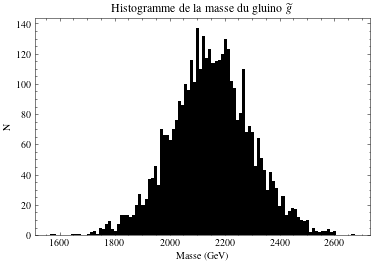

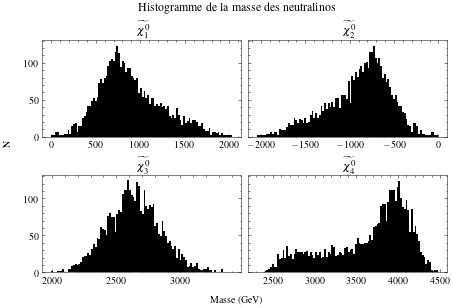

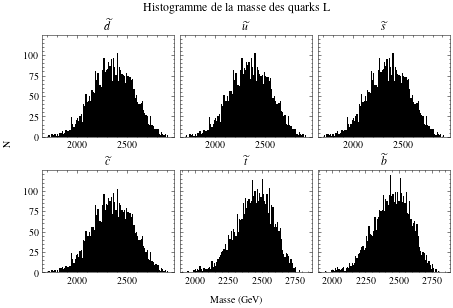

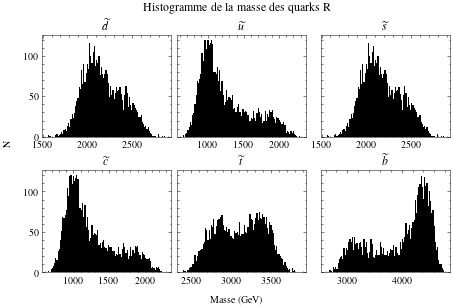

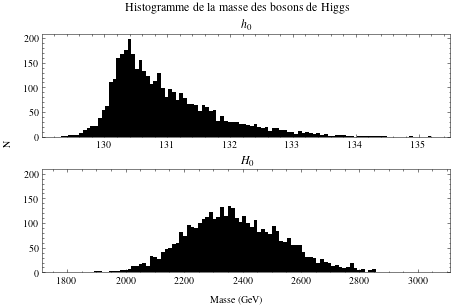

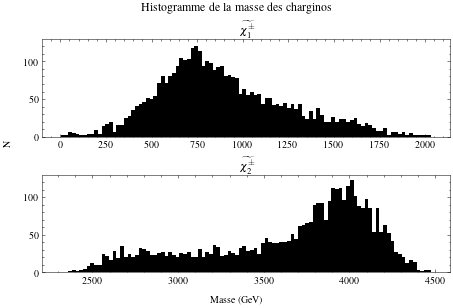

In [11]:
folder = 'Advanced NN/AL/AL_run/'+folder_name

file = '/histo_gluinos.svg'
titre = r'Histogramme de la masse du gluino $\widetilde{g}$'
xlabel = 'Masse (GeV)'
ylabel = 'N'
plot_histo(titre,xlabel,ylabel,[g_mass],100,['NN'],save=True,file_folder=folder+file)

file = '/histo_neutralinos.svg'
titre = 'Histogramme de la masse des neutralinos'
subtitle = [r'$\widetilde{\chi_1^0}$',r'$\widetilde{\chi_2^0}$',r'$\widetilde{\chi_3^0}$',r'$\widetilde{\chi_4^0}$']
share = [False,True]
subplot_histo(titre,xlabel,ylabel,2,2,share,subtitle,[neutralino_mass],['NN'],save=True,file_folder=folder+file)

file = '/histo_quarksL.svg'
titre = 'Histogramme de la masse des quarks L'
subtitle = [r'$\widetilde{d}$',r'$\widetilde{u}$',r'$\widetilde{s}$',r'$\widetilde{c}$',r'$\widetilde{t}$',r'$\widetilde{b}$']    
subplot_histo(titre,xlabel,ylabel,2,3,share,subtitle,[squarkL_mass],['NN'],save=True,file_folder=folder+file)

file = '/histo_quarksR.svg'
titre = 'Histogramme de la masse des quarks R' 
subplot_histo(titre,xlabel,ylabel,2,3,share,subtitle,[squarkR_mass],['NN'],save=True,file_folder=folder+file)

file = '/histo_higgs.svg'
titre = 'Histogramme de la masse des bosons de Higgs'    
subtitle = [r'$h_0$',r'$H_0$']
subplot_histo(titre,xlabel,ylabel,2,1,share,subtitle,[higgs_mass],['NN'],save=True,file_folder=folder+file)

file = '/histo_charginos.svg'
titre = 'Histogramme de la masse des charginos'    
subtitle = [r'$\widetilde{\chi_1^\pm}$',r'$\widetilde{\chi_2^\pm}$']
subplot_histo(titre,xlabel,ylabel,2,1,share,subtitle,[chargino_mass],['NN'],save=True,file_folder=folder+file)

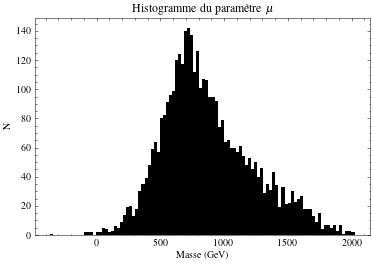

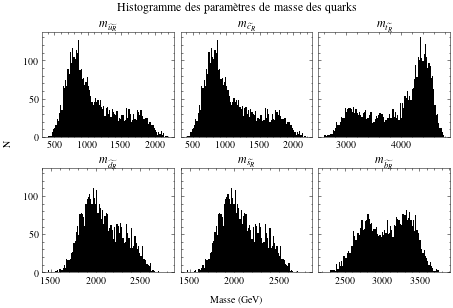

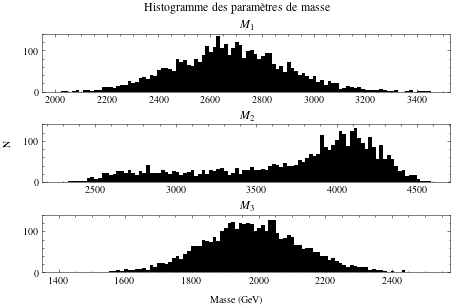

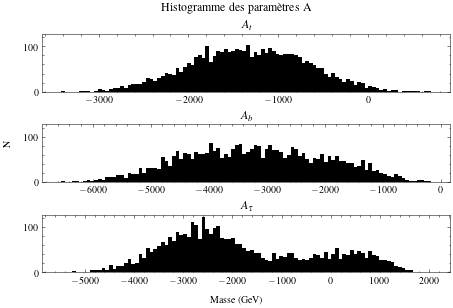

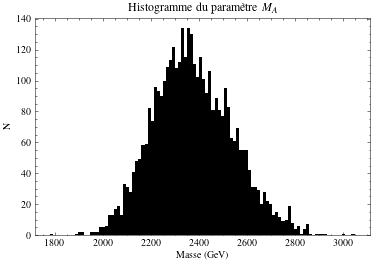

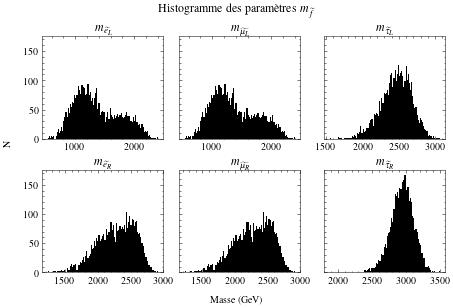

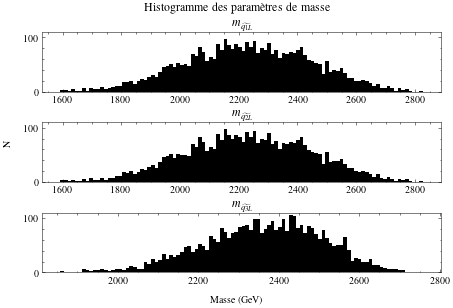

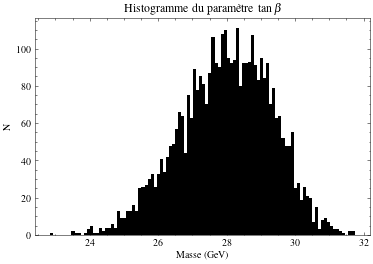

In [12]:
file = '/histo_mu.svg'
titre = r'Histogramme du paramètre $\mu$'
plot_histo(titre,xlabel,ylabel,[mu],100,['NN'],save=True,file_folder=folder+file)

file = '/histo_mquarks.svg'
titre = 'Histogramme des paramètres de masse des quarks'
subtitle = [r'$m_{\widetilde{u_R}}$',r'$m_{\widetilde{c_R}}$',r'$m_{\widetilde{t_R}}$',r'$m_{\widetilde{d_R}}$',r'$m_{\widetilde{s_R}}$',r'$m_{\widetilde{b_R}}$']
subplot_histo(titre,xlabel,ylabel,2,3,share,subtitle,[quark_param],['NN'],save=True,file_folder=folder+file)

file = '/histo_M.svg'
titre = 'Histogramme des paramètres de masse'
subtitle = [r'$M_1$',r'$M_2$',r'$M_3$']
subplot_histo(titre,xlabel,ylabel,3,1,share,subtitle,[M_param],['NN'],save=True,file_folder=folder+file)

file = '/histo_A.svg'
titre = 'Histogramme des paramètres A'
subtitle = [r'$A_t$',r'$A_b$',r'$A_\tau$']
subplot_histo(titre,xlabel,ylabel,3,1,share,subtitle,[A_param],['NN'],save=True,file_folder=folder+file)

file = '/histo_mA.svg'
titre = r'Histogramme du paramètre $M_A$'
plot_histo(titre,xlabel,ylabel,[mA_param],100,['NN'],save=True,file_folder=folder+file)

file = '/histo_mlL.svg'
titre = r'Histogramme des paramètres $m_{\widetilde{f}}$'
subtitle = [r'$m_{\widetilde{e_L}}$',r'$m_{\widetilde{\mu_L}}$',r'$m_{\widetilde{\tau_L}}$',r'$m_{\widetilde{e_R}}$',r'$m_{\widetilde{\mu_R}}$',r'$m_{\widetilde{\tau_R}}$']
subplot_histo(titre,xlabel,ylabel,2,3,share,subtitle,[mlL_param+mlR_param],['NN'],save=True,file_folder=folder+file)

file = '/histo_mqL.svg'
titre = 'Histogramme des paramètres de masse'
subtitle = [r'$m_{\widetilde{q_{1L}}}$',r'$m_{\widetilde{q_{2L}}}$',r'$m_{\widetilde{q_{3L}}}$']
subplot_histo(titre,xlabel,ylabel,3,1,share,subtitle,[mqL_param],['NN'],save=True,file_folder=folder+file)

file = '/histo_tanb.svg'
titre = r'Histogramme du paramètre $\tan \beta$'
plot_histo(titre,xlabel,ylabel,[tanB],100,['NN'],save=True,file_folder=folder+file)

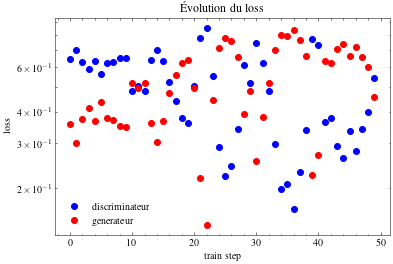

In [13]:
plt.plot([i for i in range(train_step)],loss_evolution_d,'ob',label='discriminateur')
plt.plot([i for i in range(train_step)],loss_evolution_g,'or',label='generateur')
plt.yscale("log")
plt.legend()
plt.title('Évolution du loss')
plt.xlabel('train step')
plt.ylabel('loss')
plt.savefig(folder+'/loss.pdf')

In [14]:
print('Statisique du Neural Network')
print("Nombre d'échecs:",ratio_IT[0])
print("Nombre de succes:",ratio_IT[1])
print('Nombre warning:', warning)
print('Éfficacité du AL:',100*ratio_IT[1]/(ratio_IT[0]+ratio_IT[1]),'%')
print('\n')

Statisique du Neural Network
Nombre d'échecs: 1109
Nombre de succes: 3891
Nombre warning: 0
Éfficacité du AL: 77.82 %




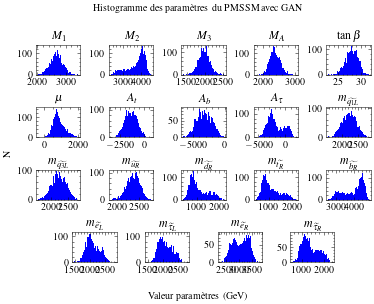

In [15]:
import matplotlib.gridspec as gridspec
color = 'blue'
titre_all = r'Histogramme des paramètres du PMSSM avec GAN10000'
subtitle_M = [r'$M_1$',r'$M_2$',r'$M_3$']
subtitle_A = [r'$A_t$',r'$A_b$',r'$A_\tau$']
subtitle_qL = [r'$m_{\widetilde{q_{1L}}}$',r'$m_{\widetilde{q_{3L}}}$']
subtitle_quark = [r'$m_{\widetilde{u_R}}$',r'$m_{\widetilde{d_R}}$',r'$m_{\widetilde{t_R}}$',r'$m_{\widetilde{b_R}}$']
subtitle_ml = [r'$m_{\widetilde{e_L}}$',r'$m_{\widetilde{\tau_L}}$',r'$m_{\widetilde{e_R}}$',r'$m_{\widetilde{\tau_R}}$']

subtitle_all = subtitle_M + [r'$M_{A}$',r'$\tan \beta$',r'$\mu$'] + subtitle_A + subtitle_qL
subtitle_all += subtitle_quark + subtitle_ml

PMSSM_all = M_param + [mA_param,tanB,mu] + A_param + mqL_param + quark_param + mlL_param + mlR_param
bins = 100

fig = plt.figure()

gs = gridspec.GridSpec(4, 10)
gs.update(wspace=3.5,hspace=1.1)

ax0 = plt.subplot(gs[0, 0:2])
ax0.hist(PMSSM_all[0],bins,color=color)
ax0.set_title(subtitle_all[0])

ax1 = plt.subplot(gs[0, 2:4])
ax1.hist(PMSSM_all[1],bins,color=color)
ax1.set_title(subtitle_all[1])

ax2 = plt.subplot(gs[0, 4:6])
ax2.hist(PMSSM_all[2],bins,color=color)
ax2.set_title(subtitle_all[2])

ax3 = plt.subplot(gs[0, 6:8])
ax3.hist(PMSSM_all[3],bins,color=color)
ax3.set_title(subtitle_all[3])

ax4 = plt.subplot(gs[0, 8:10])
ax4.hist(PMSSM_all[4],bins,color=color)
ax4.set_title(subtitle_all[4])

ax5 = plt.subplot(gs[1, 0:2])
ax5.hist(PMSSM_all[5],bins,color=color)
ax5.set_title(subtitle_all[5])

ax6 = plt.subplot(gs[1, 2:4])
ax6.hist(PMSSM_all[6],bins,color=color)
ax6.set_title(subtitle_all[6])

ax7 = plt.subplot(gs[1, 4:6])
ax7.hist(PMSSM_all[7],bins,color=color)
ax7.set_title(subtitle_all[7])

ax8 = plt.subplot(gs[1, 6:8])
ax8.hist(PMSSM_all[8],bins,color=color)
ax8.set_title(subtitle_all[8])

ax9 = plt.subplot(gs[1, 8:10])
ax9.hist(PMSSM_all[9],bins,color=color)
ax9.set_title(subtitle_all[9])

ax10 = plt.subplot(gs[2, 0:2])
ax10.hist(PMSSM_all[10],bins,color=color)
ax10.set_title(subtitle_all[10])

ax11 = plt.subplot(gs[2, 2:4])
ax11.hist(PMSSM_all[11],bins,color=color)
ax11.set_title(subtitle_all[11])

ax12 = plt.subplot(gs[2, 4:6])
ax12.hist(PMSSM_all[12],bins,color=color)
ax12.set_title(subtitle_all[12])

ax13 = plt.subplot(gs[2, 6:8])
ax13.hist(PMSSM_all[13],bins,color=color)
ax13.set_title(subtitle_all[13])

ax14 = plt.subplot(gs[2, 8:10])
ax14.hist(PMSSM_all[14],bins,color=color)
ax14.set_title(subtitle_all[14])

ax15 = plt.subplot(gs[3, 1:3])
ax15.hist(PMSSM_all[15],bins,color=color)
ax15.set_title(subtitle_all[15])

ax16 = plt.subplot(gs[3, 3:5])
ax16.hist(PMSSM_all[16],bins,color=color)
ax16.set_title(subtitle_all[16])

ax17 = plt.subplot(gs[3, 5:7])
ax17.hist(PMSSM_all[17],bins,color=color)
ax17.set_title(subtitle_all[17])

ax18 = plt.subplot(gs[3, 7:9])
ax18.hist(PMSSM_all[18],bins,color=color)
ax18.set_title(subtitle_all[18])

fig.text(0.5, 1, titre_all, ha='center')
fig.text(0.5, 0, 'Valeur paramètres (GeV)', ha='center')
fig.text(0.05, 0.5, 'N', va='center', rotation='vertical')

plt.savefig('pmssm_algan_plot.svg')
plt.show()